In [1]:
import csv

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import os

RANDOM_SEED = 42
!pip install --upgrade pip

  Using cached pip-23.3.2-py3-none-any.whl.metadata (3.5 kB)
Using cached pip-23.3.2-py3-none-any.whl (2.1 MB)


ERROR: To modify pip, please run the following command:
C:\Users\zoric\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical # needed to one-hot encode labels
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install keras-tuner
import keras_tuner as kt
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import time


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\zoric\AppData\Local\Temp\ipykernel_13392\3986942730.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# Specify each path

In [4]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [5]:
NUM_CLASSES = 8

# Dataset reading

In [6]:
X_train = np.loadtxt('model/keypoint_classifier/keypointsTrain.csv', delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 4))) #+4
y_train = np.loadtxt('model/keypoint_classifier/keypointsTrain.csv', delimiter=',', dtype='int32', usecols=(0))
X_val = np.loadtxt('model/keypoint_classifier/keypointsVal.csv', delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 4)))
y_val = np.loadtxt('model/keypoint_classifier/keypointsVal.csv', delimiter=',', dtype='int32', usecols=(0))
X_test = np.loadtxt('model/keypoint_classifier/keypointsTest.csv', delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 4)))
y_test = np.loadtxt('model/keypoint_classifier/keypointsTest.csv', delimiter=',', dtype='int32', usecols=(0))

In [8]:
#X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.8, random_state=RANDOM_SEED)

# Old Model building and training without Paramtertuning

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2 + 3, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [10]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [21]:
#Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/14 [=>............................] - ETA: 8s - loss: 2.1961 - accuracy: 0.1328
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
14/14 [==============================] - 1s 25ms/step - loss: 2.2024 - accuracy: 0.1245 - val_loss: 2.0972 - val_accuracy: 0.1370
Epoch 2/1000
 1/14 [=>............................] - ETA: 0s - loss: 2.1036 - accuracy: 0.1250
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
14/14 [==============================] - 0s 8ms/step - loss: 2.1037 - accuracy: 0.1582 - val_loss: 2.0702 - val_accuracy: 0.1781
Epoch 3/1000
 1/14 [=>............................] - ETA: 0s - loss: 2.0202 - accuracy: 0.2031
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
14/14 [==============================] - 0s 9ms/step - loss: 2.0818 - accuracy: 0.1658 - val_loss: 2.0530 - val_accuracy: 0.1712
Epoch 4/1000
 1/14 [=>............................] - ETA: 0s - loss: 2.0920 - accuracy: 0.1641


In [13]:
# Model evaluation
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=128)

2/2 [==============================] - 0s 3ms/step - loss: 0.7188 - accuracy: 0.7591


In [24]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               23552     
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 160)               41120     
                                                                 
 dense_7 (Dense)             (None, 8)                 1288      
                                                                 
Total params: 197,288
Trainable params: 197,288
Non-trainable params: 0
_________________________________________________________________


# Optimized Model building and Paramtertuning

In [8]:
def create_dir(path):
    os.makedirs(path, exist_ok=True)
create_dir("files")
model_path = os.path.join("files", "model.keras")
csv_path = os.path.join("files", "data.csv")

In [9]:
def build_model(hp):  
    model = keras.Sequential()

    # # input layer
    model.add(layers.InputLayer(21 * 2 + 3)) # make 1 dimensional array out of 21x2 array

    # # only for simple one
    # # model.add(
    # #     layers.Dense( 
    # #         units=1024,
    # #         activation="relu"
    # #     )
    # # )
    
    # # model.add(
    # #     layers.Dense( # dense = every input neuron is connected to every next neuron
    # #         units=hp.Int("units", min_value=128, max_value=1024, step=128), # tune the number of neurons
    # #         #units=1024,
    # #         #activation=hp.Choice("activation", ["relu", "tanh"]), # tune the activation function; relu should be best
    # #         activation="relu"
    # #     )
    # # )

    
    #ACTUAL ONE 
    for i in range(hp.Int('num_layers', 2, 3)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=64,
                                            max_value=512,
                                            step=32),
                               activation='relu'))

    
    # tune whether to use dropout
    if hp.Boolean("dropout"):
      model.add(layers.Dropout(rate=0.2))
    #TODO

    # output layer
    model.add(layers.Dense(8, activation="softmax")) # probability of every output neuron which all add up to 1

    # tune learning rate 
    #learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    learning_rate = 1e-3 # 1e-3 = 0.001
    
    model.compile(loss="sparse_categorical_crossentropy",
                  #optimizer="adam",
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"]
    )
    
    return model



""" Model """
tuner = RandomSearch(
    hypermodel=build_model,
    objective = 'val_accuracy', 
    max_trials = 30, # total number of trials to run during search; should be as high as all combinations possible; default is 10
    executions_per_trial = 2, # number of models that should be built and fit for each trial; executions within trial have same hyperparameter values
    directory='output', # where to store search results
    overwrite = True # overwrite previous results in same directory
)

""" Training """
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True, monitor='val_loss'),
    #ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path, append=True),
    # if within 50 epochs the val_loss does not decrease, the model will stop training
    EarlyStopping(monitor='val_accuracy', mode='max', patience=25)
]


# search best hyperparameter configuration; all arguments passed to search() are also passed to model.fit() in each execution
tuner.search(
    x = X_train,
    y = y_train,
    epochs = 400,
    batch_size = 32,
    validation_data = (X_val, y_val),
    callbacks=callbacks
)

best_model = tuner.get_best_models()[0]  # Get the best model found by the tuner
best_model.build(layers.InputLayer(21*2+3))
best_model.summary()
tuner.results_summary()

    
# RETRAIN MODEL WITH WHOLE DATASET AND BEST HYPERPARAMETERS
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("----------------------------------------------------")
print("best values:")
print(best_hps.values)
print("----------------------------------------------------")
model = build_model(best_hps)

history = model.fit(
    x = X_train,
    y = y_train,
    epochs = 400,
    batch_size = 32,
    validation_data = (X_val, y_val),
    callbacks=callbacks
)




Trial 30 Complete [00h 00m 30s]
val_accuracy: 0.9520547688007355

Best val_accuracy So Far: 0.9623287618160248
Total elapsed time: 00h 16m 33s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 288)               13248     
                                                                 
 dense_1 (Dense)             (None, 256)               73984     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 89,288
Trainable params: 89,288
Non-trainable params: 0
_________________________________________________________________
Results summary
Results in output\untitle

In [10]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 288)               13248     
                                                                 
 dense_1 (Dense)             (None, 256)               73984     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 89,288
Trainable params: 89,288
Non-trainable params: 0
_________________________________________________________________


In [12]:
# TEST
evaluation = model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 2ms/step - loss: 0.2578 - accuracy: 0.9489


# Load Saved Model

In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[1.8228071e-04 2.7754480e-05 2.1319383e-05 1.3400817e-03 1.2537706e-01
 6.0204583e-01 8.7985143e-02 1.8302052e-01]
5


# Confusion matrix

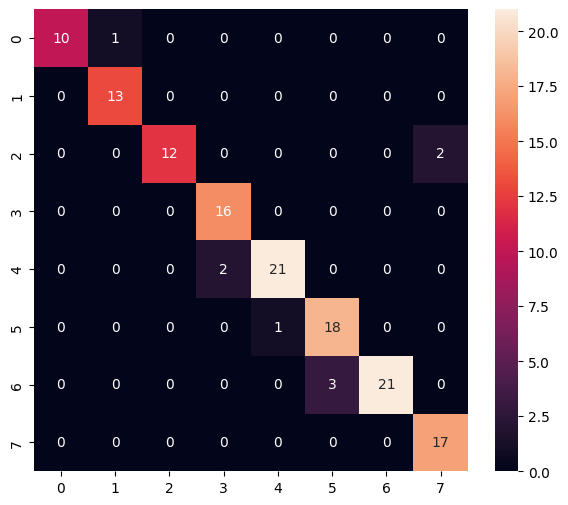

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.93      1.00      0.96        13
           2       1.00      0.86      0.92        14
           3       0.89      1.00      0.94        16
           4       0.95      0.91      0.93        23
           5       0.86      0.95      0.90        19
           6       1.00      0.88      0.93        24
           7       0.89      1.00      0.94        17

    accuracy                           0.93       137
   macro avg       0.94      0.94      0.94       137
weighted avg       0.94      0.93      0.93       137



In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
   

print_confusion_matrix(y_test, y_pred)
# class_names = ["zero", "one", "two", "three", "four", "five", "spock","other"]
# conf_matrix = confusion_matrix(y_test, y_pred)

# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

# Confusion matrix with false predicted pictures

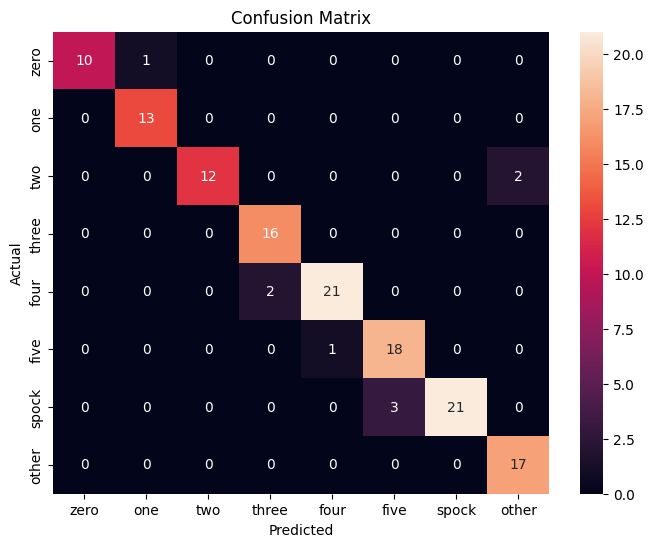

  ACTUAL LABEL PREDICTED LABEL  FILE NAME OF IMAGE
0         four           three                   4
1        spock            five                   6
2         zero             one                   0
3         five            four                   5
4         four           three                   4
5          two           other                   2
6          two           other                   0
7        spock            five                   6
8        spock            five                   0


In [12]:
# Get predictions from the model
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Create the confusion matrix
class_names = ["zero", "one", "two", "three", "four", "five", "spock","other"]
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()




# SHOW WHICH ONES HAVE BEEN PREDICTED INCORRECTLY

incorrect_indices = np.where(y_test != y_pred)[0] 
# Read the first row of the test dataset CSV file to get file names
test_file_names = pd.read_csv("model/keypoint_classifier/keypointsTest.csv", usecols=[0]).values.flatten()

# one dimensional array which contains file names of incorrect files
incorrect_files = np.array(test_file_names)[incorrect_indices] 

# Create a DataFrame for incorrectly predicted images
data = {
    'ACTUAL LABEL': [class_names[y_test[i]] for i in incorrect_indices],
    'PREDICTED LABEL': [class_names[y_pred[i]] for i in incorrect_indices],
    'FILE NAME OF IMAGE': incorrect_files
}

incorrect_df = pd.DataFrame(data)

print(incorrect_df)

# Convert to model for Tensorflow-Lite

In [17]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [18]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\zoric\AppData\Local\Temp\tmpba72nftj\assets


6692

# Inference test

In [19]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [20]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [21]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [22]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 9.6 ms


In [23]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.8228054e-04 2.7754428e-05 2.1319382e-05 1.3400816e-03 1.2537709e-01
 6.0204583e-01 8.7985128e-02 1.8302052e-01]
5
